## **RagamBatik - Klasifikasi Gambar Batik**

# Import Library

In [ ]:
# Import library
import os
import random
import shutil
import datetime
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Data Loading

In [ ]:
from google.colab import files

# Download Dataset
files.upload()

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d nadyams/indonesia-batik-dataset
!unzip -q indonesia-batik-dataset.zip -d indonesia-batik-dataset

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/nadyams/indonesia-batik-dataset
License(s): DbCL-1.0
 68% 120M/177M [00:00<00:00, 1.25GB/s]
100% 177M/177M [00:00<00:00, 1.07GB/s]


# Data Preprocessing

Kelas `Madura_Gentongan` dihapus dari dataset karena hanya memiliki **8 gambar**, jumlah yang terlalu sedikit dibandingkan kelas lain. Hal ini dilakukan untuk mencegah ketidakseimbangan ekstrem yang dapat memengaruhi kinerja model.

In [ ]:
# Hapus kelas yang tidak diinginkan
original_dataset_dir = '/content/indonesia-batik-dataset'

folder_to_remove = os.path.join(original_dataset_dir, 'Madura_Gentongan')
if os.path.exists(folder_to_remove):
    shutil.rmtree(folder_to_remove)
    print("Kelas 'Madura_Gentongan' berhasil dihapus dari dataset.")
else:
    print("Folder 'Madura_Gentongan' tidak ditemukan.")

Kelas 'Madura_Gentongan' berhasil dihapus dari dataset.


In [ ]:
# Split dataset ke train/val/test
original_dataset_dir = '/content/indonesia-batik-dataset'
base_dir = '/content/batik-dataset-split'
split_ratio = (0.7, 0.15, 0.15)  # train, val, test

for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(base_dir, split), exist_ok=True)

classes = [cls for cls in os.listdir(original_dataset_dir) if os.path.isdir(os.path.join(original_dataset_dir, cls))]

for cls in tqdm(classes, desc="Membagi dataset"):
    src_path = os.path.join(original_dataset_dir, cls)
    files = os.listdir(src_path)
    random.shuffle(files)

    n_total = len(files)
    n_train = int(n_total * split_ratio[0])
    n_val = int(n_total * split_ratio[1])

    splits = {
        'train': files[:n_train],
        'val': files[n_train:n_train + n_val],
        'test': files[n_train + n_val:]
    }

    for split in ['train', 'val', 'test']:
        dst_dir = os.path.join(base_dir, split, cls)
        os.makedirs(dst_dir, exist_ok=True)
        for fname in splits[split]:
            shutil.copy(os.path.join(src_path, fname), os.path.join(dst_dir, fname))

print("Dataset berhasil dipisah ke dalam train/val/test.")

Membagi dataset: 100%|██████████| 23/23 [00:00<00:00, 53.79it/s]

Dataset berhasil dipisah ke dalam train/val/test.


In [ ]:
# Parameter
img_size = (224, 224)
batch_size = 32

# Augmentasi Gambar untuk train
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15,
    shear_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Data Generators
train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'val'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Hitung class_weight
labels = train_generator.classes
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weight_dict = dict(enumerate(class_weights_array))

print("Class weights:", class_weight_dict)

Found 1532 images belonging to 23 classes.
Found 324 images belonging to 23 classes.
Found 340 images belonging to 23 classes.
Class weights: {0: np.float64(2.37888198757764), 1: np.float64(2.2202898550724637), 2: np.float64(2.37888198757764), 3: np.float64(0.7836317135549872), 4: np.float64(1.9031055900621119), 5: np.float64(0.2552057304680993), 6: np.float64(2.37888198757764), 7: np.float64(0.6343685300207039), 8: np.float64(2.37888198757764), 9: np.float64(2.466988727858293), 10: np.float64(2.37888198757764), 11: np.float64(2.37888198757764), 12: np.float64(2.37888198757764), 13: np.float64(2.2202898550724637), 14: np.float64(2.37888198757764), 15: np.float64(0.9515527950310559), 16: np.float64(0.59472049689441), 17: np.float64(0.4269788182831661), 18: np.float64(2.37888198757764), 19: np.float64(2.37888198757764), 20: np.float64(2.37888198757764), 21: np.float64(0.2632754768860629), 22: np.float64(1.1101449275362318)}


# Modelling

In [ ]:
# Build Model dengan Fine-tuning MobileNetV2
base_model = MobileNetV2(include_top=False, input_shape=img_size + (3,), weights='imagenet')
base_model.trainable = True  # unfreeze semua layer untuk fine-tuning

# Custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = Dropout(0.4)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,643,415 (10.08 MB)

 Trainable params: 2,606,743 (9.94 MB)

 Non-trainable params: 36,672 (143.25 KB)

In [ ]:
# Callbacks
checkpoint_path = 'best_batik_model.h5'
callbacks = [
    ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=4, verbose=1)
]

In [ ]:
# Training
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=70,
    callbacks=callbacks,
    class_weight=class_weight_dict
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0501 - loss: 4.5305
Epoch 1: val_accuracy improved from -inf to 0.05247, saving model to best_batik_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.0501 - loss: 4.5292 - val_accuracy: 0.0525 - val_loss: 3.8349 - learning_rate: 1.0000e-04
Epoch 2/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - accuracy: 0.0831 - loss: 4.2123
Epoch 2: val_accuracy improved from 0.05247 to 0.11111, saving model to best_batik_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 29s 605ms/step - accuracy: 0.0832 - loss: 4.2106 - val_accuracy: 0.1111 - val_loss: 3.6536 - learning_rate: 1.0000e-04
Epoch 3/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - accuracy: 0.1133 - loss: 3.8902
Epoch 3: val_accuracy improved from 0.11111 to 0.17284, saving model to best_batik_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 29s 604ms/step - accuracy: 0.1134 - loss: 3.8900 - val_accuracy: 0.1728 - val_loss: 3.4427 - learning_rate: 1.0000e-04
Epoch 4/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - accuracy: 0.1159 - loss: 3.7591
Epoch 4: val_accuracy improved from 0.17284 to 0.26852, saving model to best_batik_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 30s 611ms/step - accuracy: 0.1160 - loss: 3.7589 - val_accuracy: 0.2685 - val_loss: 3.2805 - learning_rate: 1.0000e-04
Epoch 5/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - accuracy: 0.1631 - loss: 3.6903
Epoch 5: val_accuracy improved from 0.26852 to 0.34568, saving model to best_batik_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 29s 600ms/step - accuracy: 0.1632 - loss: 3.6883 - val_accuracy: 0.3457 - val_loss: 3.1010 - learning_rate: 1.0000e-04
Epoch 6/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - accuracy: 0.2035 - loss: 3.5970
Epoch 6: val_accuracy improved from 0.34568 to 0.40123, saving model to best_batik_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 29s 599ms/step - accuracy: 0.2034 - loss: 3.5960 - val_accuracy: 0.4012 - val_loss: 2.9309 - learning_rate: 1.0000e-04
Epoch 7/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - accuracy: 0.2348 - loss: 3.4141
Epoch 7: val_accuracy improved from 0.40123 to 0.44136, saving model to best_batik_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 30s 618ms/step - accuracy: 0.2351 - loss: 3.4131 - val_accuracy: 0.4414 - val_loss: 2.7403 - learning_rate: 1.0000e-04
Epoch 8/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - accuracy: 0.2661 - loss: 3.3248
Epoch 8: val_accuracy improved from 0.44136 to 0.51852, saving model to best_batik_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 29s 605ms/step - accuracy: 0.2662 - loss: 3.3228 - val_accuracy: 0.5185 - val_loss: 2.5684 - learning_rate: 1.0000e-04
Epoch 9/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - accuracy: 0.3124 - loss: 3.0959
Epoch 9: val_accuracy improved from 0.51852 to 0.57407, saving model to best_batik_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 29s 606ms/step - accuracy: 0.3123 - loss: 3.0960 - val_accuracy: 0.5741 - val_loss: 2.4235 - learning_rate: 1.0000e-04
Epoch 10/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - accuracy: 0.3813 - loss: 2.9264
Epoch 10: val_accuracy improved from 0.57407 to 0.62654, saving model to best_batik_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 29s 602ms/step - accuracy: 0.3812 - loss: 2.9262 - val_accuracy: 0.6265 - val_loss: 2.3023 - learning_rate: 1.0000e-04
Epoch 11/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.3978 - loss: 2.7419
Epoch 11: val_accuracy did not improve from 0.62654
48/48 ━━━━━━━━━━━━━━━━━━━━ 28s 593ms/step - accuracy: 0.3976 - loss: 2.7419 - val_accuracy: 0.6049 - val_loss: 2.1354 - learning_rate: 1.0000e-04
Epoch 12/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.4327 - loss: 2.5371
Epoch 12: val_accuracy improved from 0.62654 to 0.63272, saving model to best_batik_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 29s 608ms/step - accuracy: 0.4329 - loss: 2.5381 - val_accuracy: 0.6327 - val_loss: 1.9958 - learning_rate: 1.0000e-04
Epoch 13/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.4706 - loss: 2.4415
Epoch 13: val_accuracy improved from 0.63272 to 0.66049, saving model to best_batik_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 30s 613ms/step - accuracy: 0.4707 - loss: 2.4428 - val_accuracy: 0.6605 - val_loss: 1.9126 - learning_rate: 1.0000e-04
Epoch 14/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - accuracy: 0.4857 - loss: 2.4045
Epoch 14: val_accuracy did not improve from 0.66049
48/48 ━━━━━━━━━━━━━━━━━━━━ 28s 588ms/step - accuracy: 0.4858 - loss: 2.4043 - val_accuracy: 0.6481 - val_loss: 1.8770 - learning_rate: 1.0000e-04
Epoch 15/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.5271 - loss: 2.2888
Epoch 15: val_accuracy improved from 0.66049 to 0.66358, saving model to best_batik_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 29s 605ms/step - accuracy: 0.5270 - loss: 2.2892 - val_accuracy: 0.6636 - val_loss: 1.7973 - learning_rate: 1.0000e-04
Epoch 16/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - accuracy: 0.5203 - loss: 2.1678
Epoch 16: val_accuracy improved from 0.66358 to 0.69753, saving model to best_batik_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 42s 619ms/step - accuracy: 0.5207 - loss: 2.1687 - val_accuracy: 0.6975 - val_loss: 1.7084 - learning_rate: 1.0000e-04
Epoch 17/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.5471 - loss: 2.1105
Epoch 17: val_accuracy improved from 0.69753 to 0.70062, saving model to best_batik_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 30s 619ms/step - accuracy: 0.5475 - loss: 2.1099 - val_accuracy: 0.7006 - val_loss: 1.6435 - learning_rate: 1.0000e-04
Epoch 18/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 574ms/step - accuracy: 0.6121 - loss: 1.8856
Epoch 18: val_accuracy improved from 0.70062 to 0.71605, saving model to best_batik_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 31s 644ms/step - accuracy: 0.6119 - loss: 1.8862 - val_accuracy: 0.7160 - val_loss: 1.6057 - learning_rate: 1.0000e-04
Epoch 19/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - accuracy: 0.6264 - loss: 1.8235
Epoch 19: val_accuracy improved from 0.71605 to 0.72840, saving model to best_batik_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 30s 619ms/step - accuracy: 0.6265 - loss: 1.8236 - val_accuracy: 0.7284 - val_loss: 1.5542 - learning_rate: 1.0000e-04
Epoch 20/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.6619 - loss: 1.7260
Epoch 20: val_accuracy improved from 0.72840 to 0.73765, saving model to best_batik_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 29s 609ms/step - accuracy: 0.6618 - loss: 1.7270 - val_accuracy: 0.7377 - val_loss: 1.5525 - learning_rate: 1.0000e-04
Epoch 21/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - accuracy: 0.6440 - loss: 1.6860
Epoch 21: val_accuracy improved from 0.73765 to 0.76235, saving model to best_batik_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 31s 631ms/step - accuracy: 0.6441 - loss: 1.6860 - val_accuracy: 0.7623 - val_loss: 1.5210 - learning_rate: 1.0000e-04
Epoch 22/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.6653 - loss: 1.6121
Epoch 22: val_accuracy improved from 0.76235 to 0.78395, saving model to best_batik_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 29s 610ms/step - accuracy: 0.6654 - loss: 1.6121 - val_accuracy: 0.7840 - val_loss: 1.4818 - learning_rate: 1.0000e-04
Epoch 23/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.7048 - loss: 1.5865
Epoch 23: val_accuracy improved from 0.78395 to 0.78704, saving model to best_batik_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 30s 633ms/step - accuracy: 0.7049 - loss: 1.5858 - val_accuracy: 0.7870 - val_loss: 1.4395 - learning_rate: 1.0000e-04
Epoch 24/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - accuracy: 0.7053 - loss: 1.5007
Epoch 24: val_accuracy did not improve from 0.78704
48/48 ━━━━━━━━━━━━━━━━━━━━ 28s 591ms/step - accuracy: 0.7054 - loss: 1.5005 - val_accuracy: 0.7809 - val_loss: 1.4371 - learning_rate: 1.0000e-04
Epoch 25/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.7253 - loss: 1.4157
Epoch 25: val_accuracy did not improve from 0.78704
48/48 ━━━━━━━━━━━━━━━━━━━━ 29s 592ms/step - accuracy: 0.7255 - loss: 1.4158 - val_accuracy: 0.7840 - val_loss: 1.4462 - learning_rate: 1.0000e-04
Epoch 26/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - accuracy: 0.7376 - loss: 1.3910
Epoch 26: val_accuracy improved from 0.78704 to 0.79630, saving model to best_batik_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 42s 628ms/step - accuracy: 0.7374 - loss: 1.3915 - val_accuracy: 0.7963 - val_loss: 1.4447 - learning_rate: 1.0000e-04
Epoch 27/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.7414 - loss: 1.3772
Epoch 27: val_accuracy improved from 0.79630 to 0.80247, saving model to best_batik_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 29s 609ms/step - accuracy: 0.7414 - loss: 1.3769 - val_accuracy: 0.8025 - val_loss: 1.4251 - learning_rate: 1.0000e-04
Epoch 28/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.7689 - loss: 1.2923
Epoch 28: val_accuracy improved from 0.80247 to 0.83025, saving model to best_batik_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 29s 609ms/step - accuracy: 0.7688 - loss: 1.2929 - val_accuracy: 0.8302 - val_loss: 1.3751 - learning_rate: 1.0000e-04
Epoch 29/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.7842 - loss: 1.3014
Epoch 29: val_accuracy did not improve from 0.83025
48/48 ━━━━━━━━━━━━━━━━━━━━ 29s 604ms/step - accuracy: 0.7843 - loss: 1.3002 - val_accuracy: 0.8210 - val_loss: 1.3603 - learning_rate: 1.0000e-04
Epoch 30/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - accuracy: 0.7883 - loss: 1.2193
Epoch 30: val_accuracy did not improve from 0.83025
48/48 ━━━━━━━━━━━━━━━━━━━━ 28s 590ms/step - accuracy: 0.7886 - loss: 1.2183 - val_accuracy: 0.8272 - val_loss: 1.3471 - learning_rate: 1.0000e-04
Epoch 31/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - accuracy: 0.8372 - loss: 1.0933
Epoch 31: val_accuracy improved from 0.83025 to 0.83333, saving model to best_batik_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 29s 600ms/step - accuracy: 0.8369 - loss: 1.0939 - val_accuracy: 0.8333 - val_loss: 1.3862 - learning_rate: 1.0000e-04
Epoch 32/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - accuracy: 0.8021 - loss: 1.2126
Epoch 32: val_accuracy did not improve from 0.83333
48/48 ━━━━━━━━━━━━━━━━━━━━ 29s 606ms/step - accuracy: 0.8023 - loss: 1.2120 - val_accuracy: 0.8210 - val_loss: 1.3813 - learning_rate: 1.0000e-04
Epoch 33/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - accuracy: 0.8238 - loss: 1.1784
Epoch 33: val_accuracy did not improve from 0.83333
48/48 ━━━━━━━━━━━━━━━━━━━━ 28s 591ms/step - accuracy: 0.8237 - loss: 1.1783 - val_accuracy: 0.8333 - val_loss: 1.3595 - learning_rate: 1.0000e-04
Epoch 34/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.8401 - loss: 1.1114
Epoch 34: val_accuracy did not improve from 0.83333

Epoch 34: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
48/48 ━━━━━━━━━━━━━━━━━━━━ 28s 592ms/step - accuracy: 0.8403 - los

48/48 ━━━━━━━━━━━━━━━━━━━━ 29s 606ms/step - accuracy: 0.8479 - loss: 1.0705 - val_accuracy: 0.8426 - val_loss: 1.3480 - learning_rate: 3.0000e-05
Epoch 36/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 0.8441 - loss: 1.0677
Epoch 36: val_accuracy improved from 0.84259 to 0.85802, saving model to best_batik_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 30s 611ms/step - accuracy: 0.8439 - loss: 1.0685 - val_accuracy: 0.8580 - val_loss: 1.3363 - learning_rate: 3.0000e-05
Epoch 37/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.8386 - loss: 1.0651
Epoch 37: val_accuracy did not improve from 0.85802
48/48 ━━━━━━━━━━━━━━━━━━━━ 29s 593ms/step - accuracy: 0.8387 - loss: 1.0649 - val_accuracy: 0.8580 - val_loss: 1.3303 - learning_rate: 3.0000e-05
Epoch 38/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.8398 - loss: 1.0942
Epoch 38: val_accuracy did not improve from 0.85802
48/48 ━━━━━━━━━━━━━━━━━━━━ 30s 616ms/step - accuracy: 0.8400 - loss: 1.0934 - val_accuracy: 0.8580 - val_loss: 1.3311 - learning_rate: 3.0000e-05
Epoch 39/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.8495 - loss: 1.0928
Epoch 39: val_accuracy did not improve from 0.85802
48/48 ━━━━━━━━━━━━━━━━━━━━ 40s 596ms/step - accuracy: 0.8496 - loss: 1.0921 - val_accuracy: 0.8549 - val_loss: 1.3264 - learning_rate: 3.0000e-05

48/48 ━━━━━━━━━━━━━━━━━━━━ 41s 606ms/step - accuracy: 0.8539 - loss: 1.0900 - val_accuracy: 0.8704 - val_loss: 1.3056 - learning_rate: 3.0000e-05
Epoch 43/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - accuracy: 0.8756 - loss: 0.9985
Epoch 43: val_accuracy improved from 0.87037 to 0.87654, saving model to best_batik_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 29s 601ms/step - accuracy: 0.8756 - loss: 0.9987 - val_accuracy: 0.8765 - val_loss: 1.3034 - learning_rate: 3.0000e-05
Epoch 44/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.8706 - loss: 1.0253
Epoch 44: val_accuracy did not improve from 0.87654
48/48 ━━━━━━━━━━━━━━━━━━━━ 29s 599ms/step - accuracy: 0.8707 - loss: 1.0250 - val_accuracy: 0.8642 - val_loss: 1.3111 - learning_rate: 3.0000e-05
Epoch 45/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.8861 - loss: 0.9381
Epoch 45: val_accuracy did not improve from 0.87654
48/48 ━━━━━━━━━━━━━━━━━━━━ 29s 601ms/step - accuracy: 0.8859 - loss: 0.9384 - val_accuracy: 0.8765 - val_loss: 1.3093 - learning_rate: 3.0000e-05
Epoch 46/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.8903 - loss: 0.9976
Epoch 46: val_accuracy did not improve from 0.87654
48/48 ━━━━━━━━━━━━━━━━━━━━ 28s 593ms/step - accuracy: 0.8901 - loss: 0.9975 - val_accuracy: 0.8704 - val_loss: 1.3038 - learning_rate: 3.0000e-05

48/48 ━━━━━━━━━━━━━━━━━━━━ 29s 604ms/step - accuracy: 0.8950 - loss: 0.9716 - val_accuracy: 0.8796 - val_loss: 1.2856 - learning_rate: 3.0000e-05
Epoch 53/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.8685 - loss: 1.0165
Epoch 53: val_accuracy did not improve from 0.87963
48/48 ━━━━━━━━━━━━━━━━━━━━ 29s 594ms/step - accuracy: 0.8688 - loss: 1.0156 - val_accuracy: 0.8765 - val_loss: 1.2788 - learning_rate: 3.0000e-05
Epoch 54/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.8896 - loss: 0.9370
Epoch 54: val_accuracy did not improve from 0.87963
48/48 ━━━━━━━━━━━━━━━━━━━━ 30s 620ms/step - accuracy: 0.8897 - loss: 0.9371 - val_accuracy: 0.8796 - val_loss: 1.2780 - learning_rate: 3.0000e-05
Epoch 55/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.9035 - loss: 0.8818
Epoch 55: val_accuracy did not improve from 0.87963
48/48 ━━━━━━━━━━━━━━━━━━━━ 28s 589ms/step - accuracy: 0.9034 - loss: 0.8824 - val_accuracy: 0.8704 - val_loss: 1.2963 - learning_rate: 3.0000e-05

In [ ]:
# Load Model dari Checkpoint Terbaik
model.load_weights(checkpoint_path)
print("Model terbaik berhasil dimuat dari checkpoint.")

# Compile Ulang Model dengan Learning Rate Kecil
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # lebih kecil agar fine-tuning halus
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
print("Model dikompilasi ulang dengan learning rate lebih kecil (1e-5).")

Model terbaik berhasil dimuat dari checkpoint.
Model dikompilasi ulang dengan learning rate lebih kecil (1e-5).


In [ ]:
# Fine-Tuning Lanjutan
history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    initial_epoch=history.epoch[-1] + 1,
    callbacks=callbacks,
    class_weight=class_weight_dict
)

print("Fine-tuning lanjutan selesai.")

Epoch 65/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 983ms/step - accuracy: 0.8940 - loss: 0.9187
Epoch 65: val_accuracy improved from 0.87963 to 0.88272, saving model to best_batik_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.8941 - loss: 0.9186 - val_accuracy: 0.8827 - val_loss: 1.2817 - learning_rate: 1.0000e-05
Epoch 66/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.9067 - loss: 0.9030
Epoch 66: val_accuracy improved from 0.88272 to 0.88580, saving model to best_batik_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 30s 617ms/step - accuracy: 0.9065 - loss: 0.9032 - val_accuracy: 0.8858 - val_loss: 1.2739 - learning_rate: 1.0000e-05
Epoch 67/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - accuracy: 0.8826 - loss: 0.9684
Epoch 67: val_accuracy did not improve from 0.88580
48/48 ━━━━━━━━━━━━━━━━━━━━ 28s 583ms/step - accuracy: 0.8826 - loss: 0.9686 - val_accuracy: 0.8858 - val_loss: 1.2766 - learning_rate: 1.0000e-05
Epoch 68/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.8922 - loss: 0.9494
Epoch 68: val_accuracy did not improve from 0.88580
48/48 ━━━━━━━━━━━━━━━━━━━━ 28s 579ms/step - accuracy: 0.8922 - loss: 0.9495 - val_accuracy: 0.8827 - val_loss: 1.2774 - learning_rate: 1.0000e-05
Epoch 69/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 554ms/step - accuracy: 0.9138 - loss: 0.8896
Epoch 69: val_accuracy did not improve from 0.88580
48/48 ━━━━━━━━━━━━━━━━━━━━ 29s 609ms/step - accuracy: 0.9137 - loss: 0.8899 - val_accuracy: 0.8827 - val_loss: 1.2779 - learning_rate: 1.0000e

48/48 ━━━━━━━━━━━━━━━━━━━━ 29s 597ms/step - accuracy: 0.9142 - loss: 0.9038 - val_accuracy: 0.8889 - val_loss: 1.2745 - learning_rate: 9.0000e-07
Epoch 76/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - accuracy: 0.9135 - loss: 0.8727
Epoch 76: val_accuracy did not improve from 0.88889
48/48 ━━━━━━━━━━━━━━━━━━━━ 30s 627ms/step - accuracy: 0.9133 - loss: 0.8732 - val_accuracy: 0.8889 - val_loss: 1.2736 - learning_rate: 9.0000e-07
Epoch 77/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.8908 - loss: 0.9275
Epoch 77: val_accuracy did not improve from 0.88889
48/48 ━━━━━━━━━━━━━━━━━━━━ 28s 592ms/step - accuracy: 0.8909 - loss: 0.9274 - val_accuracy: 0.8889 - val_loss: 1.2721 - learning_rate: 9.0000e-07
Epoch 78/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - accuracy: 0.9127 - loss: 0.9423
Epoch 78: val_accuracy improved from 0.88889 to 0.89198, saving model to best_batik_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 29s 597ms/step - accuracy: 0.9126 - loss: 0.9422 - val_accuracy: 0.8920 - val_loss: 1.2719 - learning_rate: 9.0000e-07
Epoch 79/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 574ms/step - accuracy: 0.9037 - loss: 0.9342
Epoch 79: val_accuracy did not improve from 0.89198
48/48 ━━━━━━━━━━━━━━━━━━━━ 29s 610ms/step - accuracy: 0.9036 - loss: 0.9345 - val_accuracy: 0.8920 - val_loss: 1.2728 - learning_rate: 9.0000e-07
Epoch 80/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - accuracy: 0.9051 - loss: 0.8836
Epoch 80: val_accuracy did not improve from 0.89198
48/48 ━━━━━━━━━━━━━━━━━━━━ 29s 599ms/step - accuracy: 0.9052 - loss: 0.8838 - val_accuracy: 0.8920 - val_loss: 1.2714 - learning_rate: 9.0000e-07
Epoch 81/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - accuracy: 0.9066 - loss: 0.9233
Epoch 81: val_accuracy did not improve from 0.89198
48/48 ━━━━━━━━━━━━━━━━━━━━ 29s 603ms/step - accuracy: 0.9065 - loss: 0.9229 - val_accuracy: 0.8920 - val_loss: 1.2700 - learning_rate: 9.0000e

# Evaluation

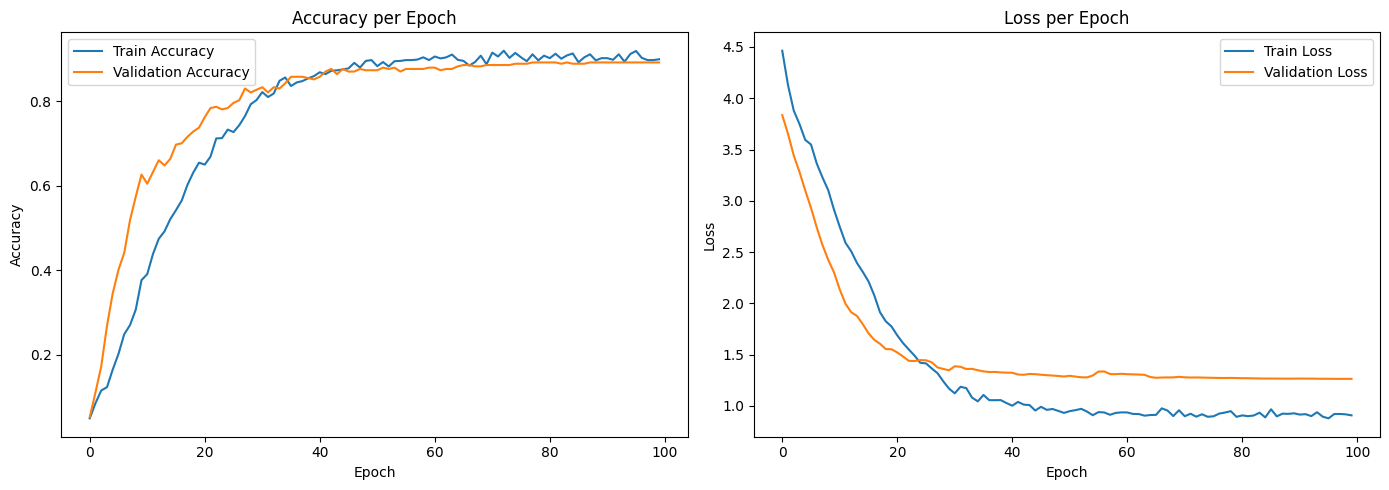

In [ ]:
# Gabungkan history awal dan fine-tuning
def combine_histories(h1, h2):
    combined_history = {}
    for key in h1.history.keys():
        combined_history[key] = h1.history[key] + h2.history[key]
    return combined_history

full_history = combine_histories(history, history_finetune)

# Plot Akurasi
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(full_history['accuracy'], label='Train Accuracy')
plt.plot(full_history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(full_history['loss'], label='Train Loss')
plt.plot(full_history['val_loss'], label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluasi Akurasi
best_epoch = np.argmax(full_history['val_accuracy'])
best_val_acc = full_history['val_accuracy'][best_epoch]
best_train_acc = full_history['accuracy'][best_epoch]

print(f"Training Accuracy: {best_train_acc:.4f}")
print(f"Validation Accuracy: {best_val_acc:.4f}")

Training Accuracy: 0.9112
Validation Accuracy: 0.8920


In [ ]:
# Evaluasi Train Set
train_loss, train_acc = model.evaluate(train_generator, verbose=1)
print(f"Akurasi di Train Set (Best Epoch): {train_acc:.4f}")

# Evaluasi Validation Set
val_loss, val_acc = model.evaluate(val_generator, verbose=1)
print(f"Akurasi di Validation Set (Best Epoch): {val_acc:.4f}")

# Evaluasi Test Set
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"Akurasi di Test Set: {test_acc:.4f}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 28s 591ms/step - accuracy: 0.9847 - loss: 0.7426
Akurasi di Train Set (Best Epoch): 0.9850
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.8964 - loss: 1.2679
Akurasi di Validation Set (Best Epoch): 0.8920
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 478ms/step - accuracy: 0.9072 - loss: 0.9978
Akurasi di Test Set: 0.8735


11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 432ms/step


<Figure size 1400x1000 with 0 Axes>

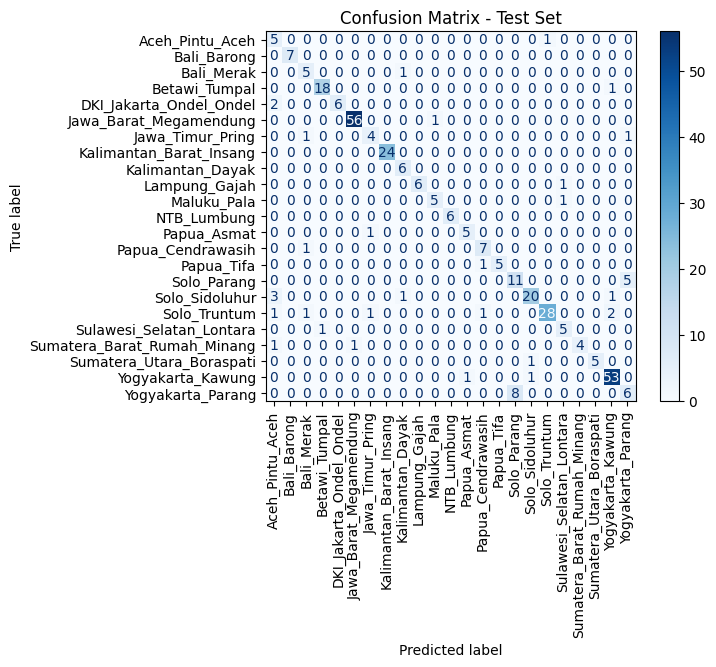

In [ ]:
# Prediksi kelas
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
labels = list(test_generator.class_indices.keys())

plt.figure(figsize=(14, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=90, cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Test Set")
plt.show()

# Inference

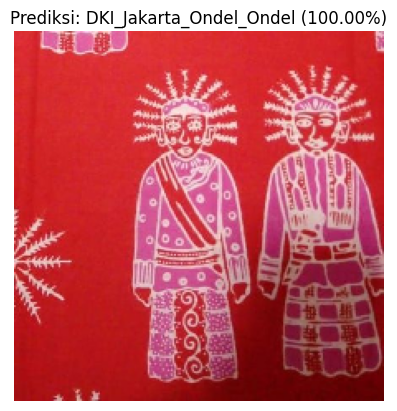

('DKI_Jakarta_Ondel_Ondel', np.float32(0.9999616))

In [ ]:
# Fungsi prediksi
def predict_image(img_path, model, class_indices, target_size=(224, 224)):
    # Load & preprocess image
    if not os.path.exists(img_path):
        print(f"Error: File not found at {img_path}")
        return None, None

    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Prediksi
    prediction = model.predict(img_array, verbose=0)
    predicted_class = np.argmax(prediction[0])
    class_labels = list(class_indices.keys())
    confidence = prediction[0][predicted_class]

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediksi: {class_labels[predicted_class]} ({confidence:.2%})")
    plt.show()

    return class_labels[predicted_class], confidence

# Path Image
img_path = '/content/indonesia-batik-dataset/DKI_Jakarta_Ondel_Ondel/Ondel (26).jpg'

predict_image(img_path, model, test_generator.class_indices)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


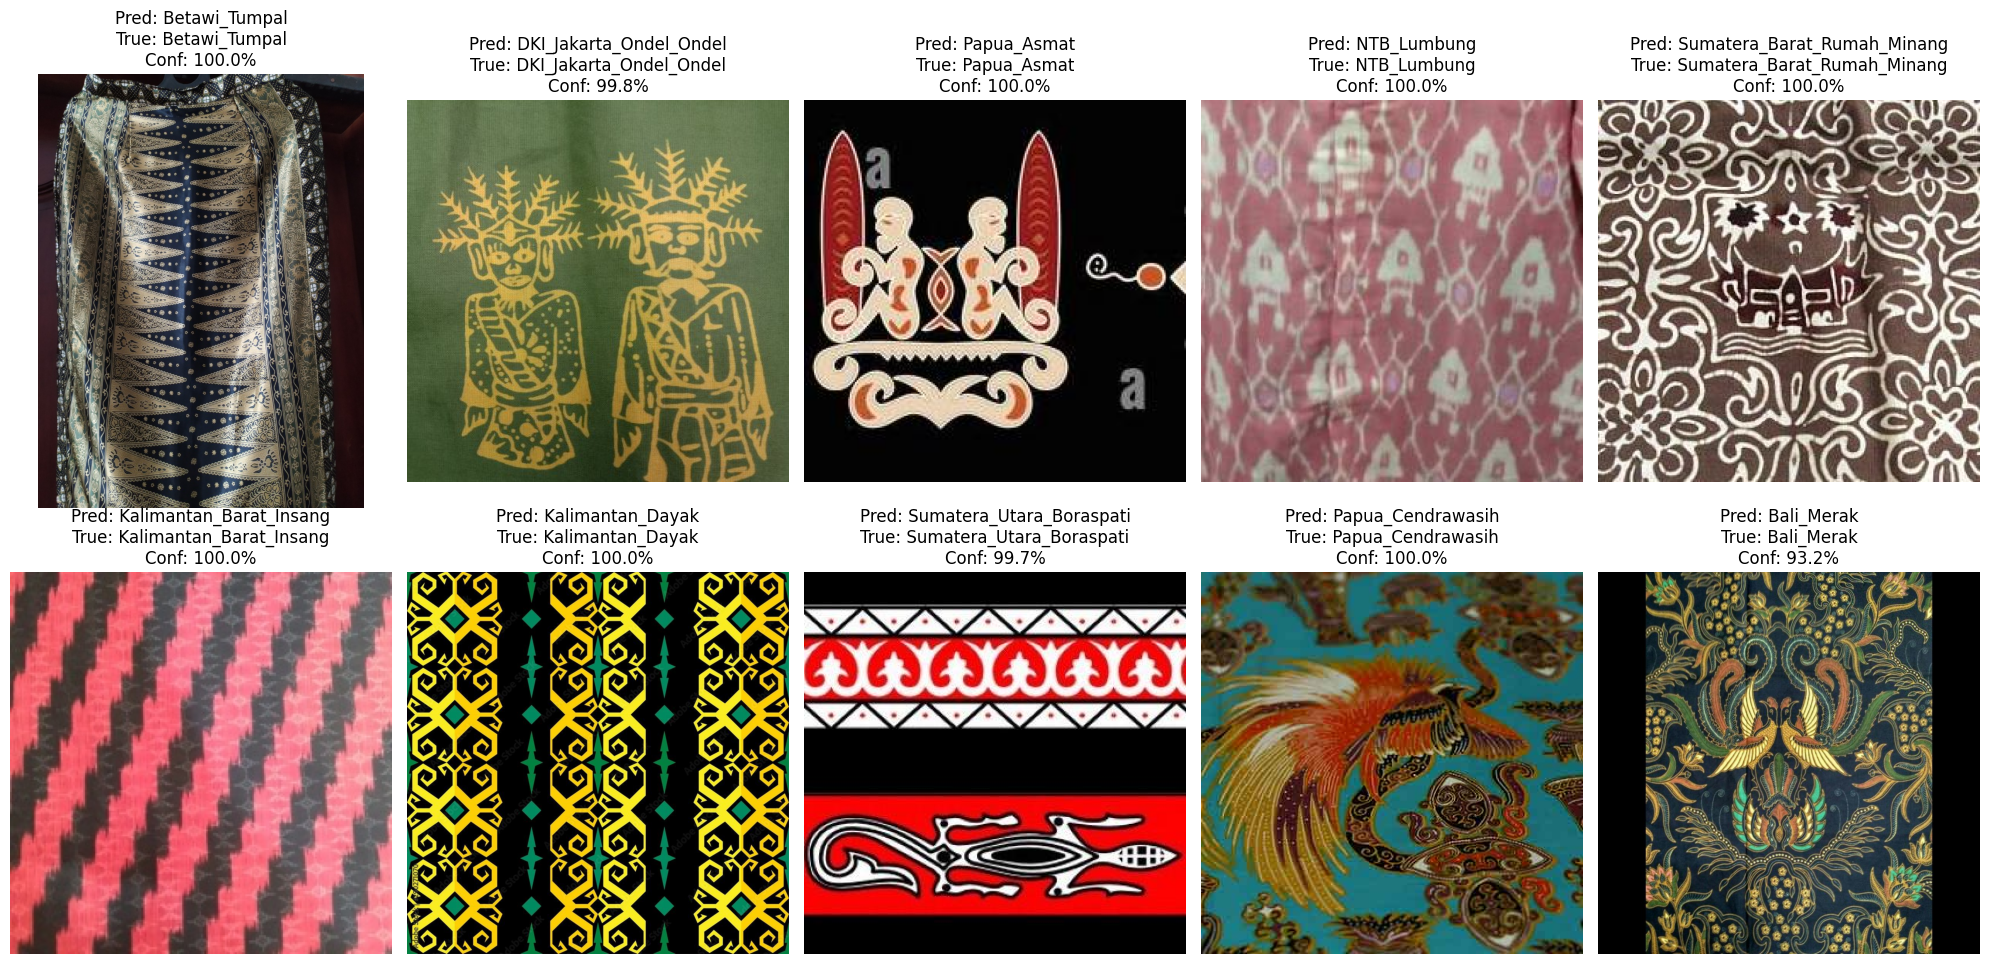

In [ ]:
# Path ke folder test
test_data_dir = 'batik-dataset-split/test'
img_size = (224, 224)

# Ambil semua nama kelas, lalu acak dan pilih 10 kelas unik
class_names = os.listdir(test_data_dir)
selected_classes = random.sample(class_names, 10)

selected_images = []
selected_labels = []

# Ambil 1 gambar random dari tiap kelas
for cls in selected_classes:
    cls_path = os.path.join(test_data_dir, cls)
    img_name = random.choice(os.listdir(cls_path))
    img_path = os.path.join(cls_path, img_name)
    selected_images.append(img_path)
    selected_labels.append(cls)

plt.figure(figsize=(20, 10))

for i, img_path in enumerate(selected_images):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    pred = model.predict(img_array)
    predicted_class = np.argmax(pred)
    predicted_label = list(train_generator.class_indices.keys())[predicted_class]
    confidence = np.max(pred) * 100

    plt.subplot(2, 5, i + 1)
    plt.imshow(image.load_img(img_path))
    plt.axis('off')
    plt.title(f'Pred: {predicted_label}\nTrue: {selected_labels[i]}\nConf: {confidence:.1f}%')

plt.tight_layout()
plt.show()

In [ ]:
# Mengambil prediksi dari model
Y_pred_all = model.predict(test_generator, verbose=1)
y_pred_all = np.argmax(Y_pred_all, axis=1)
confidences_all = np.max(Y_pred_all, axis=1)
y_true_all = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Mengumpulkan confidence untuk setiap kelas yang diprediksi dengan benar
average_confidences = {}

for i in range(len(y_true_all)):
    true_idx = y_true_all[i]
    pred_idx = y_pred_all[i]
    confidence = confidences_all[i]

    if true_idx == pred_idx:
        class_name = class_labels[true_idx]
        if class_name not in average_confidences:
            average_confidences[class_name] = []
        average_confidences[class_name].append(confidence)

# Menampilkan rata-rata confidence per kelas (untuk prediksi yang benar)
print("\nRata-rata Confidence Prediksi yang Benar per Kelas:")
for class_name in class_labels:
    confidences = average_confidences.get(class_name, [])
    if confidences:
        avg_conf = np.mean(confidences)
        print(f"- {class_name}: {avg_conf:.2%}")
    else:
        print(f"- {class_name}: (Tidak ada prediksi yang benar)")

# Rata-rata confidence keseluruhan (semua prediksi)
average_confidence_overall = np.mean(confidences_all)
print(f"\nRata-rata Confidence Keseluruhan (Semua Prediksi): {average_confidence_overall:.2%}")

# Rata-rata confidence hanya untuk prediksi yang benar
correct_indices = np.where(y_true_all == y_pred_all)[0]
if len(correct_indices) > 0:
    average_confidence_correct = np.mean(confidences_all[correct_indices])
    print(f"Rata-rata Confidence Hanya untuk Prediksi yang Benar: {average_confidence_correct:.2%}")
else:
    print("Tidak ada prediksi yang benar di test set.")

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step

Rata-rata Confidence Prediksi yang Benar per Kelas:
- Aceh_Pintu_Aceh: 92.81%
- Bali_Barong: 99.66%
- Bali_Merak: 98.18%
- Betawi_Tumpal: 95.29%
- DKI_Jakarta_Ondel_Ondel: 99.65%
- Jawa_Barat_Megamendung: 97.73%
- Jawa_Timur_Pring: 100.00%
- Kalimantan_Barat_Insang: 98.71%
- Kalimantan_Dayak: 99.70%
- Lampung_Gajah: 98.06%
- Maluku_Pala: 96.97%
- NTB_Lumbung: 99.97%
- Papua_Asmat: 99.98%
- Papua_Cendrawasih: 99.99%
- Papua_Tifa: 97.94%
- Solo_Parang: 89.56%
- Solo_Sidoluhur: 88.09%
- Solo_Truntum: 98.43%
- Sulawesi_Selatan_Lontara: 93.66%
- Sumatera_Barat_Rumah_Minang: 93.44%
- Sumatera_Utara_Boraspati: 99.71%
- Yogyakarta_Kawung: 91.94%
- Yogyakarta_Parang: 81.26%

Rata-rata Confidence Keseluruhan (Semua Prediksi): 91.83%
Rata-rata Confidence Hanya untuk Prediksi yang Benar: 95.53%


# Save Model

In [ ]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.34.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [ ]:
import tensorflowjs as tfjs

# Mengonversi model ke format TensorFlow.js
tfjs.converters.save_keras_model(model, 'model_tfjs')

failed to lookup keras version from the file,
    this is likely a weight only file


In [ ]:
import shutil
from google.colab import files

shutil.make_archive('model_tfjs', 'zip', 'model_tfjs')

files.download('model_tfjs.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>